# Compare slit profile with reference profile

First try it out by hand for a single slit

In [1]:
from pathlib import Path
import yaml
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import seaborn as sns

import mes_longslit as mes


In [2]:
dpath = Path.cwd().parent / "data"

List of data for each Ha slit exposure:

In [3]:
slit_db_list = yaml.safe_load(
    (dpath / "slits-ha.yml").read_text()
)

Photometric reference image:

In [4]:
photom, = fits.open(dpath / "regrid" / "ha-imslit-median.fits")
wphot = WCS(photom.header)

To start off with, we will analyze a single slit:

In [5]:
db = slit_db_list[0]
db

{'slit_id': 'N10036',
 'orig_file': 'crN10036_bx.fits',
 'image_id': 'N10035',
 'line_id': 'Ha',
 'slit_width': 70,
 'comment': 'Just E of center.'}

Get the HDUs for both the slit spectrum and the image+slit. The spectrum file names are very variable, so we have an `orig_file` entry in the database:

In [6]:
spec_hdu, = fits.open(dpath / "originals" / db["orig_file"])

But the image file names are more regular and can be derived from the `image_id` entry:

In [7]:
im_hdu, = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")

There is no sign of any saturated pixels in any of the exposures, so we can miss out that step.

Add in extra fields to database:

- `wa` wavelength axis (1 or 2, fits order) in PV spectrum
- `ij` slit orientation in I+S (1=vertical, 2=horizontal)

In [8]:
if db["slit_id"].startswith("N"):
    db["wa"] = 2
    db["ij"] = 2
else:
    db["wa"] = 1
    db["ij"] = 1
db["s"] = 1

In [9]:
spec_hdu.data = mes.subtract_sky_and_trim(
    spec_hdu.data, db, trim=5, margin=50)

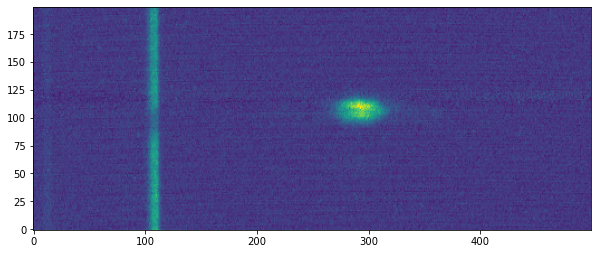

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(spec_hdu.data[250:450, 200:700], origin="lower");

So that does a reasonably good job of subtracting the background emission line

Lines to avoid when calculating the continuum

In [11]:
restwavs = {'ha': 6562.79, 'nii': 6583.45, 'nii_s': 6548.05}

In [12]:
spec_profile = mes.extract_full_profile_from_pv(
    spec_hdu,
    wavaxis=db["wa"],
    bandwidth=90.0,
    linedict=restwavs,
)

This is the position of the slit in pixel coordinates.

In [13]:
db["islit"] = 442

In [14]:
imslit_profile = mes.extract_slit_profile_from_imslit(
    im_hdu.data, db, slit_width=2,
)

442


In [15]:
jslit = np.arange(len(spec_profile))


In [16]:
spec_profile.shape, imslit_profile.shape

((998,), (998,))

### Find a better way to do the alignment

In [17]:
jwin_slice = slice(340, 700)
shift_guess = 100
jwin_slice_shift = slice(
    jwin_slice.start - shift_guess, 
    jwin_slice.stop - shift_guess,
)

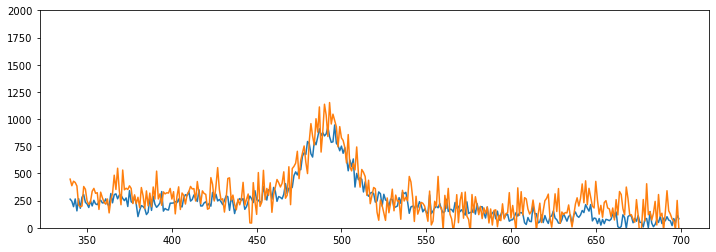

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit[jwin_slice], (imslit_profile[jwin_slice_shift] + 20) * 10)
ax.plot(jslit[jwin_slice], spec_profile[jwin_slice])
ax.set(yscale="linear", ylim=[0, 2000]);



We need to find the alignment along the slit.  Just use the initial guess for now.

In [19]:
j0_s = np.average(jslit[jwin_slice], weights=spec_profile[jwin_slice])
j0_i = np.average(jslit[jwin_slice_shift], weights=(20 + imslit_profile[jwin_slice_shift]))
db["shift"] = j0_s - j0_i
j0_s, j0_i, db["shift"]

(493.7199792981562, 386.3959812146874, 107.32399808346878)

In [20]:
slit_coords = mes.find_slit_coords(db, im_hdu.header, spec_hdu.header)

iarr = [-107.32399808   -7.32399808   92.67600192  192.67600192  292.67600192
  392.67600192  492.67600192  592.67600192  692.67600192  792.67600192] jarr = [441. 441. 441. 441. 441. 441. 441. 441. 441. 441.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58462395, 43.64504555), (318.58457064, 43.6547826 ),
     (318.58451731, 43.66451965), (318.58446397, 43.67425671),
     (318.5844106 , 43.68399376), (318.58435722, 43.69373081),
     (318.58430382, 43.70346786), (318.58425041, 43.71320492),
     (318.58419698, 43.72294196), (318.58414353, 43.73267901)]>
Binning along slit: image = 2 spectrum = 2


In [21]:
slit_coords['Dec'].shape, jslit.shape

((998,), (998,))

In [22]:
calib_profile = mes.slit_profile(
    slit_coords['RA'], 
    slit_coords['Dec'],
    photom.data, 
    wphot,
)

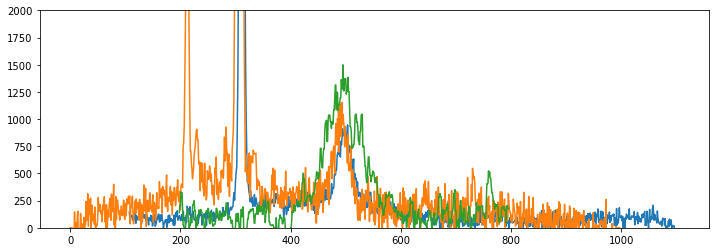

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + db["shift"], (imslit_profile + 20) * 10)
ax.plot(jslit, spec_profile)
ax.plot(jslit, calib_profile * 1000)
ax.set(yscale="linear", ylim=[0, 2000]);

In [24]:
calib_profile[::100]

array([        nan,         nan,  0.20199096,  0.01533964, -0.00164539,
        1.37182423,  0.10281527,  0.15895278,         nan,         nan])

In [25]:
spec_profile[::100]

array([   0.      ,  225.79276 ,  163.69476 , 4635.577   ,  264.5596  ,
        827.00867 ,   88.730415,  125.566895,   66.914856,   55.108917],
      dtype=float32)

In [26]:
slit_points = (np.arange(len(spec_profile)) - j0_s)*slit_coords["ds"]

In [27]:
jslice0 = slice(int(j0_s)-20, int(j0_s)+20)

In [28]:
rat0 = np.nansum(spec_profile[jslice0]) / np.nansum(calib_profile[jslice0])
print('Coarse calibration: ratio =', rat0)

Coarse calibration: ratio = 665.9779980734522


In [29]:
spec_profile[jslice0]

array([ 594.1304 ,  703.7793 ,  451.8403 ,  620.8064 ,  686.9629 ,
        752.66705,  603.8045 ,  498.79114,  793.7714 ,  958.4102 ,
        842.11865,  761.1905 , 1003.2281 ,  879.97327, 1111.7639 ,
        696.51416,  885.3976 , 1136.5725 , 1036.7394 ,  839.6254 ,
       1151.9852 ,  954.7328 , 1045.1339 ,  985.8812 ,  929.49506,
        744.6921 ,  930.5743 ,  827.00867,  803.6172 ,  739.8469 ,
        596.09564,  857.6288 ,  560.88574,  523.76855,  592.2994 ,
        532.6206 ,  743.5393 ,  501.80664,  373.93997,  536.2504 ],
      dtype=float32)

In [30]:
calib_profile[jslice0]

array([0.97602133, 0.91433353, 0.97394545, 0.97394545, 0.95409182,
       1.08153204, 1.08153204, 1.18463791, 1.3135067 , 1.3135067 ,
       1.08663672, 1.24575676, 1.24575676, 1.07878598, 1.13314452,
       1.13314452, 1.14395657, 1.1961886 , 1.1961886 , 1.36256807,
       1.2792358 , 1.2792358 , 1.49883616, 1.26120298, 1.26120298,
       1.3703512 , 1.37182423, 1.37182423, 1.2294657 , 1.25756612,
       1.25756612, 1.3847537 , 1.25276291, 1.25276291, 1.1042277 ,
       0.92886733, 0.92886733, 0.89029457, 0.73128324, 0.73128324])

In [31]:
spec_profile /= rat0

In [32]:
figpath = Path.cwd().parent / "figs"
figpath.mkdir(exist_ok=True)

In [33]:
plt_prefix = figpath / f"{db['slit_id']}-calib"
mes.make_three_plots(
    spec_profile, 
    calib_profile, 
    plt_prefix,
    slit_points=slit_points,
    neighbors=None,
    db=db, 
    sdb=slit_coords,
)

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/mes_longslit/slit_utils.py:468: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes[0].set_xscale("symlog", linthreshx=0.01)
/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/mes_longslit/slit_utils.py:469: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes[0].set_yscale("symlog", linthreshy=0.01)
/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/mes_longslit/slit_utils.py:499: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes[1].set_yscale("symlog", linthreshy=0.01)
